In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from numpy import asarray
from numpy import sqrt

from pandas import concat
from pandas import DataFrame

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras import Sequential

from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [2]:
#import raw dataset

file = "C:\\Users\\tops-machine\\Projects\\507_508\\Volve production data.xlsx"
sheet = "Daily Production Data"

df = pd.read_excel(file, sheet)

In [3]:
#define columns to drop
drop_cols = ['NPD_FIELD_CODE', 'NPD_FIELD_NAME', 'NPD_FACILITY_CODE', 'NPD_FACILITY_NAME', 'AVG_CHOKE_UOM']

#drop columns and assign new dataframe
df_new = df.drop(columns = drop_cols)

#drop injection wells data
df_new = df_new[ (df['NPD_WELL_BORE_CODE'] != 5693) & (df['NPD_WELL_BORE_CODE'] != 5769) ]

#Data is highly skewed, hence pad the missing values
for col in df_new.columns:
    df_new[col] = df_new[col].fillna(method='pad')
    
#create dataframe dictionary where each key corresponds to each well
df_dict = {well_code:df_new[df_new.NPD_WELL_BORE_CODE == well_code]
           for well_code in df_new['NPD_WELL_BORE_CODE'].unique()}

#drop new columns inplace
for well_code in df_dict:
    new_drop_cols = ["WELL_BORE_CODE", "NPD_WELL_BORE_CODE", "NPD_WELL_BORE_NAME", 
                     "BORE_WI_VOL", "FLOW_KIND", "WELL_TYPE"]
    
    df_dict[well_code] = df_dict[well_code].drop(columns = new_drop_cols)
    df_dict[well_code] = df_dict[well_code].set_index('DATEPRD')
    

print(df_dict.keys())
df_dict[7405]

dict_keys([7405, 7078, 5599, 5351, 7289])


,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_ANNULUS_PRESS,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL
DATEPRD,,,,,,,,,,,,
2014-04-07,0.0,0.00000,0.00000,0.00000,0.0,0.000000,0.00000,0.00000,0.00000,0.0,0.0,0.0
2014-04-08,0.0,0.00000,0.00000,0.00000,0.0,1.003059,0.00000,0.00000,0.00000,0.0,0.0,0.0
2014-04-09,0.0,0.00000,0.00000,0.00000,0.0,0.979008,0.00000,0.00000,0.00000,0.0,0.0,0.0
2014-04-10,0.0,0.00000,0.00000,0.00000,0.0,0.545759,0.00000,0.00000,0.00000,0.0,0.0,0.0
2014-04-11,0.0,310.37614,96.87589,277.27826,0.0,1.215987,33.09788,10.47992,33.07195,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2016-04-17,0.0,270.26849,101.19807,263.77035,0.0,0.000000,6.49814,9.80247,2.64528,0.0,0.0,0.0
2016-04-18,0.0,276.86895,101.23102,263.15498,0.0,0.000000,13.71397,11.74224,4.12000,0.0,0.0,0.0
2016-04-19,0.0,282.10538,101.17754,273.52959,0.0,0.265188,8.57579,10.11906,1.86628,0.0,0.0,0.0


In [37]:
#function to get well data given the well code
def get_df(well_code):
    return df_dict[well_code]

#function to get test & train data given the well code
def get_test_and_train_data(well_code):

    well_df = get_df(well_code)

    X = well_df.drop(columns = ["BORE_OIL_VOL", "BORE_GAS_VOL", "BORE_WAT_VOL"])
    y = well_df[["BORE_OIL_VOL", "BORE_GAS_VOL", "BORE_WAT_VOL"]]
    
    return train_test_split(X, y, test_size = 0.3, random_state=42)

def get_outputs(well_code):
    well_df = get_df(well_code)
    
    return tuple([well_df[col] for col in ["BORE_OIL_VOL", "BORE_GAS_VOL", "BORE_WAT_VOL"]])

#print (get_outputs(7405)[0])

DATEPRD
2014-04-07    0.0
2014-04-08    0.0
2014-04-09    0.0
2014-04-10    0.0
2014-04-11    0.0
             ... 
2016-04-17    0.0
2016-04-18    0.0
2016-04-19    0.0
2016-04-20    0.0
2016-04-21    0.0
Name: BORE_OIL_VOL, Length: 746, dtype: float64


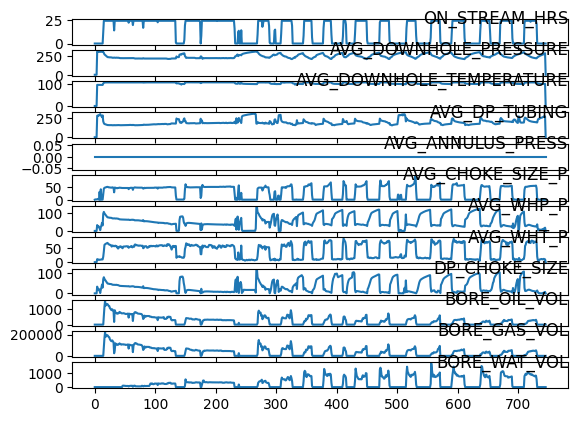

In [23]:
well_code = 7405
well_df = get_df(well_code)
X_train, X_test, y_train, y_test = get_test_and_train_data(well_code)

# specify columns to plot
n = len(well_df.columns)
i = 1

arr = well_df.to_numpy()

# plot each column
plt.figure()

for col_num in range(n):
    
    plt.subplot(n, 1, i)
    plt.plot(arr[:, col_num])
    plt.title(well_df.columns[col_num], y=0.5, loc='right')
    
    i += 1
    
plt.show()

In [ ]:
#pd.plotting.scatter_matrix(X_train, alpha=0.2, figsize=(6, 6), diagonal="hist")

#  MLP

In [24]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# determine the number of input & output features
features_in = X_train.shape[1]
features_out = y_train.shape[1]

# define model
mlp = Sequential()
mlp.add(Dense(10, activation='relu', kernel_initializer='he_normal', input_shape=(features_in,)))
mlp.add(Dense(8, activation='relu', kernel_initializer='he_normal'))
mlp.add(Dense(features_out))

# compile the model
mlp.compile(optimizer='adam', loss='mse')

# fit the model
mlp.fit(X_train, y_train, epochs=150, batch_size=32, verbose=0)

# evaluate the model
error = mlp.evaluate(X_test, y_test, verbose=2)
print('MSE: %.3f, RMSE: %.3f' % (error, sqrt(error)))


(522, 9) (224, 9) (522, 3) (224, 3)
7/7 - 0s - loss: 263315472.0000
MSE: 263315472.000, RMSE: 16226.998


# RNN - lstm

#univariate

In [39]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    
    for i in range(len(sequence)):
        
        # find the end of this pattern
        end_ix = i + n_steps
        
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
            
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
        
    return asarray(X), asarray(y)

# load the dataset
oil_prod = get_outputs(7405)[0]

# retrieve the values
values = oil_prod.values.astype('float32')

# specify the window size
n_steps = 7

# split into samples
X, y = split_sequence(values, n_steps)

# reshape into [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

# split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# define model
model = Sequential()
model.add(LSTM(100, activation='relu', kernel_initializer='he_normal', input_shape=(n_steps,1)))
model.add(Dense(50, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(50, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(1))

# compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# fit the model
model.fit(X_train, y_train, epochs=350, batch_size=32, verbose=2, validation_data=(X_test, y_test))

# evaluate the model
mse, mae = model.evaluate(X_test, y_test, verbose=0)
print('MSE: %.3f, RMSE: %.3f, MAE: %.3f' % (mse, sqrt(mse), mae))

# make a prediction
#row = asarray([18024.0, 16722.0, 14385.0, 21342.0, 17180.0]).reshape((1, n_steps, 1))
#yhat = model.predict(row)
#print('Predicted: %.3f' % (yhat))

(517, 7, 1) (222, 7, 1) (517,) (222,)


NotImplementedError: Cannot convert a symbolic Tensor (lstm/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [ ]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())